In [200]:
# Import necessary libraries
import pandas as pd 
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords


In [201]:
# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abubakar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [202]:
# Load datasets
df_train =pd.read_csv('C:/Users/Abubakar/Documents/Data Tutorial/Projects/Twitter sentiment/twitter_training.csv')
df_val = pd.read_csv('C:/Users/Abubakar/Documents/Data Tutorial/Projects/Twitter sentiment/twitter_validation.csv')

In [203]:
# Check for duplicates and null values in training and validation datasets
df_train.duplicated().sum()
df_val.duplicated().sum()

df_train.isnull().sum()
df_val.isnull().sum()

3364                                                                                                                                                                                                                                                  0
Facebook                                                                                                                                                                                                                                              0
Irrelevant                                                                                                                                                                                                                                            0
I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣    0
dtype: i

In [204]:
df_train.info()
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column                                                                                                                                                                                                                                     

In [205]:
df_train.dropna(inplace=True)

df_val.dropna(inplace=True)

In [206]:
df_train = df_train.drop_duplicates()

df_val = df_val.drop_duplicates()

In [207]:
# Rename the columns in df_train
df_train.rename(columns= {'2401': 'Tweet ID'}, inplace=True)
df_train.rename(columns= {'Borderlands': 'Entity'}, inplace=True)
df_train.rename(columns= {'im getting on borderlands and i will murder you all ,': 'Tweet content'}, inplace=True)
df_train.rename(columns= {'Positive': 'sentiment'}, inplace=True)

In [208]:
# Rename the columns in df_val
df_val.rename(columns= {'3364': 'Tweet ID'}, inplace=True)
df_val.rename(columns= {'Facebook': 'Entity'}, inplace=True)
df_val.rename(columns= {'Irrelevant': 'sentiment'}, inplace=True)
df_val.rename(columns={
    "I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his": "Tweet content"
}, inplace=True)


In [209]:
df_val.columns = ['Tweet content' if i == 3 else col for i, col in enumerate(df_val.columns)]


In [210]:
# Function to clean the tweets
def clean_tweet(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtag symbol
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

In [211]:
df_train['cleaned_text'] = df_train['Tweet content'].apply(clean_tweet)
df_val['cleaned_text'] = df_val['Tweet content'].apply(clean_tweet)

In [212]:
# Print the exact column names in the training dataset
print(df_train.columns)


Index(['Tweet ID', 'Entity', 'sentiment', 'Tweet content', 'cleaned_text'], dtype='object')


In [213]:
df_train.head(20)

,Tweet ID,Entity,sentiment,Tweet content,cleaned_text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you all
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im getting into borderlands and i can murder y...
5,2402,Borderlands,Positive,So I spent a few hours making something for fu...,so i spent a few hours making something for fu...
6,2402,Borderlands,Positive,So I spent a couple of hours doing something f...,so i spent a couple of hours doing something f...
7,2402,Borderlands,Positive,So I spent a few hours doing something for fun...,so i spent a few hours doing something for fun...
8,2402,Borderlands,Positive,So I spent a few hours making something for fu...,so i spent a few hours making something for fu...
9,2402,Borderlands,Positive,2010 So I spent a few hours making something f...,2010 so i spent a few hours making something f...


In [214]:
# Print the column names in the training dataset
print(df_val.columns)

Index(['Tweet ID', 'Entity', 'sentiment', 'Tweet content', 'cleaned_text'], dtype='object')


In [215]:
# Initialize the CountVectorizer to convert text data into a matrix of token counts
vectorizer = CountVectorizer()
# Transform the cleaned text from the training dataset into feature vectors (X) and extract the sentiment labels (y)
X = vectorizer.fit_transform(df_train['cleaned_text'])
y = df_train['sentiment']  


In [216]:
# Split the dataset into training and testing sets (80% for training, 20% for testing) with a fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [217]:
# Initialize and train the Multinomial Naive Bayes model using the training data (X_train) and labels (y_train)
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [218]:
# Use the trained model to make predictions on the test data (X_test)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Irrelevant       0.80      0.57      0.66      2455
    Negative       0.70      0.85      0.77      4433
     Neutral       0.83      0.61      0.70      3532
    Positive       0.69      0.81      0.74      3911

    accuracy                           0.73     14331
   macro avg       0.75      0.71      0.72     14331
weighted avg       0.75      0.73      0.73     14331



In [219]:
# Create a function to Remove punctuation, Convert to lowercase and Remove stopwords
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [220]:
df_train['cleaned_text'] = df_train['Tweet content'].apply(preprocess_text)

In [221]:
new_tweets = ['I love this product!', 'This is the worst experience ever.', 'I think this product is alright']
new_tweets_cleaned = [preprocess_text(tweet) for tweet in new_tweets]
new_tweets_vectorized = vectorizer.transform(new_tweets_cleaned)
predictions = model.predict(new_tweets_vectorized)
print(predictions)


['Positive' 'Negative' 'Neutral']


C:\Users\Abubakar\AppData\Local\Temp\ipykernel_28536\2371361272.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


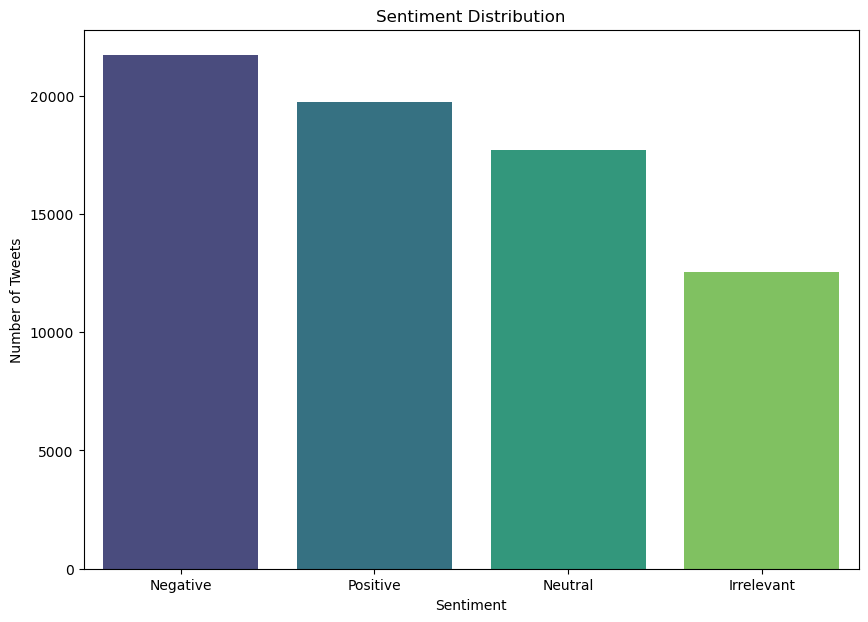

In [222]:
# Count the occurrences of each sentiment label in the 'sentiment' column and store the result in sentiment_counts
sentiment_counts = df_train['sentiment'].value_counts()

# Visualize the result
plt.figure(figsize=(10,7))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()


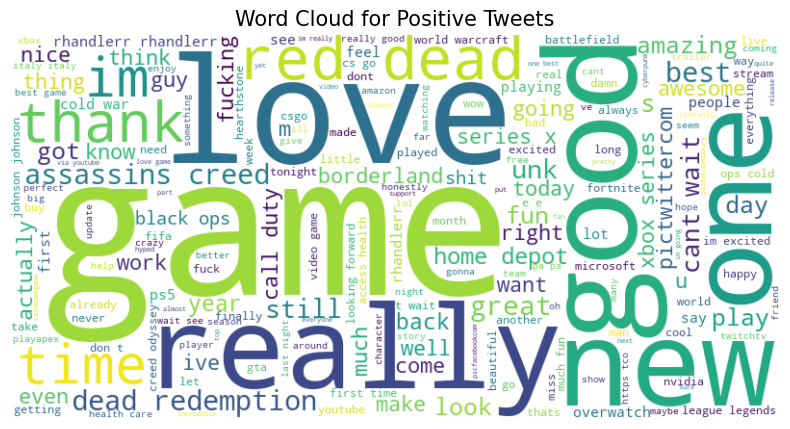

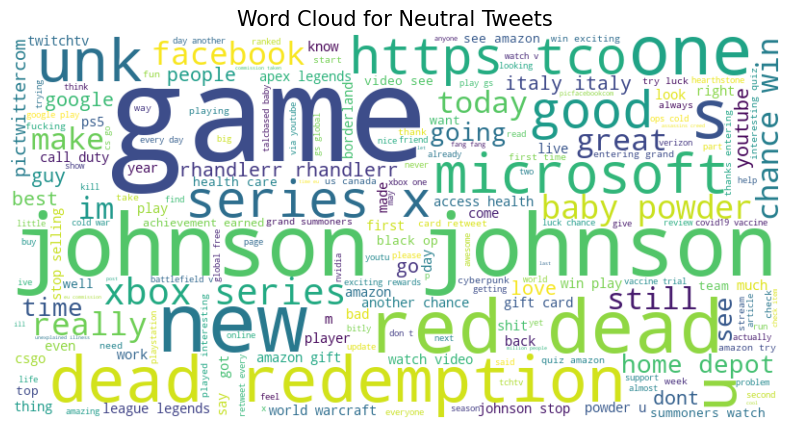

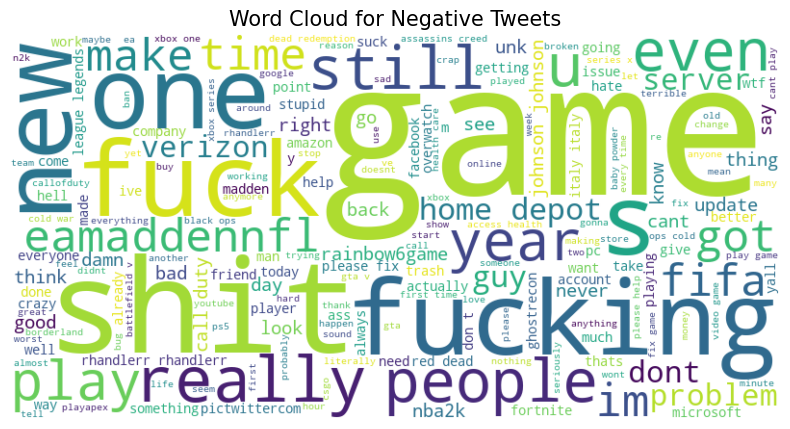

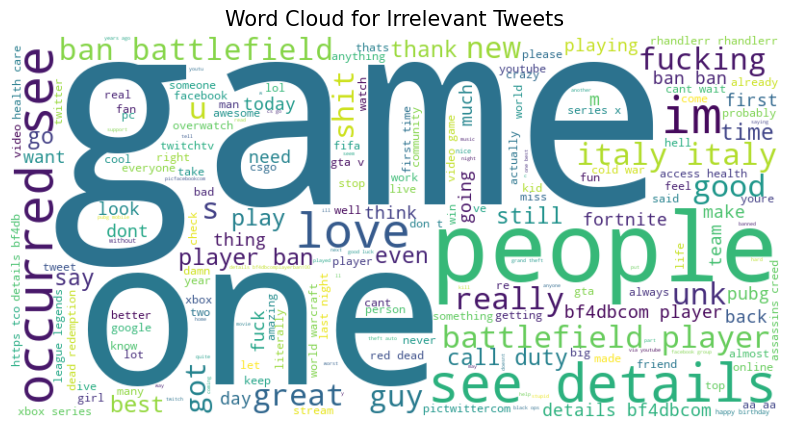

In [223]:
# Function to generate word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

# Generate word clouds for each sentiment
for sentiment in df_train['sentiment'].unique():
    text = ' '.join(df_train[df_train['sentiment'] == sentiment]['cleaned_text'])
    generate_wordcloud(text, f'Word Cloud for {sentiment.capitalize()} Tweets')


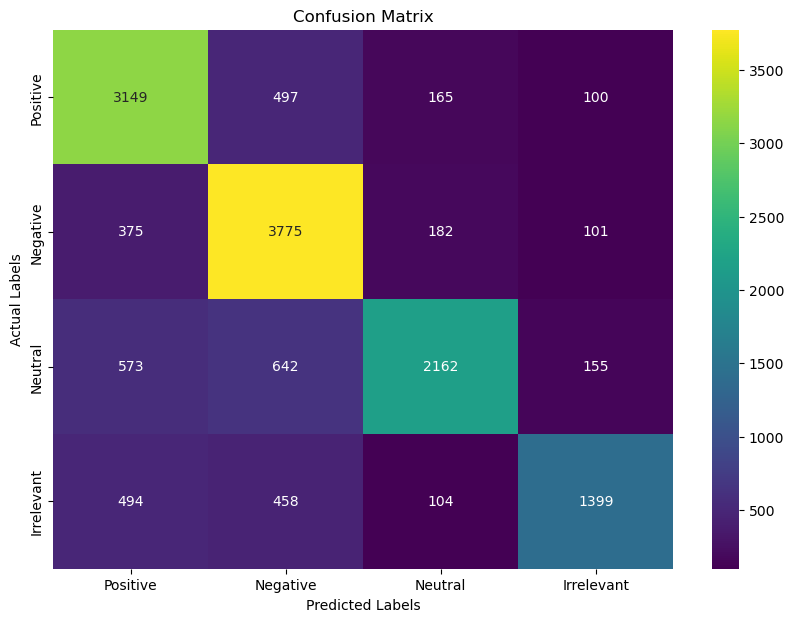

In [224]:
# Generate a heatmap visualization for the confusion matrix to analyze classification performance
# The confusion matrix compares actual sentiment labels with the model's predicted sentiment labels
cm = confusion_matrix(y_test, y_pred, labels=['Positive', 'Negative', 'Neutral', 'Irrelevant'])

# Visualize the result
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Positive', 'Negative', 'Neutral', 'Irrelevant'], yticklabels=['Positive', 'Negative', 'Neutral', 'Irrelevant'])
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()


In [225]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print classification report for a detailed evaluation of the model's performance
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.80      0.57      0.66      2455
    Negative       0.70      0.85      0.77      4433
     Neutral       0.83      0.61      0.70      3532
    Positive       0.69      0.81      0.74      3911

    accuracy                           0.73     14331
   macro avg       0.75      0.71      0.72     14331
weighted avg       0.75      0.73      0.73     14331



In [226]:

# Calculate accuracy, precision, recall, and f1-score individually
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # weighted to account for class imbalance
recall = recall_score(y_test, y_pred, average='weighted')        # weighted to account for class imbalance
f1 = f1_score(y_test, y_pred, average='weighted')                # weighted to account for class imbalance

# Display the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Weighted): {f1:.4f}")


Accuracy: 0.7316
Precision (Weighted): 0.7450
Recall (Weighted): 0.7316
F1-Score (Weighted): 0.7276


In [227]:

# Cross-validation to check for overfitting
cv_scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Average cross-validation score: {cv_scores.mean():.4f}")

# Compare training score vs. cross-validation score to check for overfitting
train_score = model.score(X_train, y_train)
print(f"Training accuracy: {train_score:.4f}")
print(f"Validation (Cross-validation) accuracy: {cv_scores.mean():.4f}")


Cross-validation scores: [0.51071105 0.44483986 0.41762613 0.40541483 0.4901263 ]
Average cross-validation score: 0.4537
Training accuracy: 0.7877
Validation (Cross-validation) accuracy: 0.4537


# Twitter Sentiment Analysis Project

## Project Overview
A **Twitter Sentiment Analysis** using **Naive Bayes** to classify tweets into sentiments like **Positive**, **Negative**, **Neutral**, and **Irrelevant**.

## Key Steps
- **Data Preprocessing**: Cleaned tweet texts by removing URLs, mentions, hashtags, and special characters.
- **Model Training**: Used the **Multinomial Naive Bayes** classifier to train the model on processed tweet data.
- **Evaluation**: Evaluated the model using classification metrics like **precision**, **recall**, and **F1-score**, along with **cross-validation** to ensure it isn't overfitting.

## Results & Insights
- **Confusion Matrix**: Visualized the performance with a **heatmap** showing predicted vs. actual sentiments.
- **Word Clouds**: Generated **word clouds** for each sentiment to visualize common words in **positive**, **negative**, and **neutral** tweets.